In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download vivektalwar13071999/final-oralv1

100% 1.05G/1.05G [00:47<00:00, 30.6MB/s]
100% 1.05G/1.05G [00:47<00:00, 23.5MB/s]


In [6]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip /content/final-oralv1.zip

Archive:  /content/final-oralv1.zip
  inflating: final_oral/test/non-suspicious/1_0GMsu0AKOlhyYfpSr5DGMJRZLlzwVuFj.jpg  
  inflating: final_oral/test/non-suspicious/1_0Jtkq6tpjENPYGcmwOEeF1kv5yTelaUi.jpg  
  inflating: final_oral/test/non-suspicious/1_0hFhiB4U85CWQYBHYDmkNq14whOOKX6G.jpg  
  inflating: final_oral/test/non-suspicious/1_0jVhFFCsdUtUEC1Ao6KW555kyfSnRxjA.jpg  
  inflating: final_oral/test/non-suspicious/1_11CxWXdQLKtNda92rfxBGQoYFEwrUlVT.jpg  
  inflating: final_oral/test/non-suspicious/1_16ipgfD9jYe9JFy5RO8yeWnYmGfBbxoF.jpg  
  inflating: final_oral/test/non-suspicious/1_19e1bzOUVdJqdTneNkJXcJw32eDNnU9d.jpg  
  inflating: final_oral/test/non-suspicious/1_1Db0wCHeLVAFqDructEaSj6vX6PKMzN3.jpg  
  inflating: final_oral/test/non-suspicious/1_22XKwuf5tBsGQv6f6WdvoVSMYJhmANnk.jpg  
  inflating: final_oral/test/non-suspicious/1_27bd9bTcsiDex4b8W595lpl0aNUpHpvC.jpg  
  inflating: final_oral/test/non-suspicious/1_2ak4W1TUxHZAN823iH19zMGexfPlmRsq.jpg  
  inflating: final_oral/test/

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# We use a butterfly dataset of 50 species to demonstrate the classification method

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [10]:
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 4.1 MB/s 
     |████████████████████████████████| 182 kB 48.8 MB/s 


In [11]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline


In [13]:
import sys
from tqdm import tqdm
import time
import copy

In [14]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [15]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
            T.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "val/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)


In [16]:

dataset_path = "/content/final_oral"

In [17]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [18]:

classes = get_classes("/content/final_oral/train/")
print(classes, len(classes))

['non-suspicious', 'suspicious'] 2


In [19]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [20]:
print(len(train_loader), len(val_loader), len(test_loader))



11 13 14


In [21]:

print(train_data_len, valid_data_len, test_data_len)


1344 412 422


In [22]:


# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [23]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_small_patch16_224', pretrained=True)


Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_small_patch16_224-cd65a155.pth" to /root/.cache/torch/hub/checkpoints/deit_small_patch16_224-cd65a155.pth


  0%|          | 0.00/84.2M [00:00<?, ?B/s]

In [24]:

for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.head)


Sequential(
  (0): Linear(in_features=384, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
)


In [25]:


criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

In [26]:

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [27]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [28]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler) # now it is a lot faster
# I will come back after 10 epochs

Epoch 0/14
----------


100%|██████████| 11/11 [07:25<00:00, 40.49s/it]


train Loss: 0.6046 Acc: 0.6882


100%|██████████| 13/13 [02:12<00:00, 10.23s/it]


val Loss: 0.5755 Acc: 0.7476

Epoch 1/14
----------


100%|██████████| 11/11 [07:22<00:00, 40.23s/it]


train Loss: 0.5355 Acc: 0.7701


100%|██████████| 13/13 [02:16<00:00, 10.50s/it]


val Loss: 0.5441 Acc: 0.7646

Epoch 2/14
----------


100%|██████████| 11/11 [07:16<00:00, 39.72s/it]


train Loss: 0.5159 Acc: 0.7798


100%|██████████| 13/13 [02:15<00:00, 10.43s/it]


val Loss: 0.5437 Acc: 0.7500

Epoch 3/14
----------


100%|██████████| 11/11 [07:20<00:00, 40.08s/it]


train Loss: 0.4852 Acc: 0.8028


100%|██████████| 13/13 [02:15<00:00, 10.42s/it]


val Loss: 0.5432 Acc: 0.7476

Epoch 4/14
----------


100%|██████████| 11/11 [07:17<00:00, 39.81s/it]


train Loss: 0.4768 Acc: 0.7984


100%|██████████| 13/13 [02:16<00:00, 10.47s/it]


val Loss: 0.5338 Acc: 0.7476

Epoch 5/14
----------


100%|██████████| 11/11 [07:19<00:00, 39.94s/it]


train Loss: 0.4580 Acc: 0.8222


100%|██████████| 13/13 [02:16<00:00, 10.51s/it]


val Loss: 0.5452 Acc: 0.7549

Epoch 6/14
----------


100%|██████████| 11/11 [07:26<00:00, 40.63s/it]


train Loss: 0.4475 Acc: 0.8311


100%|██████████| 13/13 [02:16<00:00, 10.52s/it]


val Loss: 0.5255 Acc: 0.7597

Epoch 7/14
----------


100%|██████████| 11/11 [07:22<00:00, 40.20s/it]


train Loss: 0.4436 Acc: 0.8348


100%|██████████| 13/13 [02:17<00:00, 10.57s/it]


val Loss: 0.5160 Acc: 0.7840

Epoch 8/14
----------


100%|██████████| 11/11 [07:26<00:00, 40.62s/it]


train Loss: 0.4208 Acc: 0.8549


100%|██████████| 13/13 [02:21<00:00, 10.85s/it]


val Loss: 0.5234 Acc: 0.7840

Epoch 9/14
----------


100%|██████████| 11/11 [07:26<00:00, 40.60s/it]


train Loss: 0.4073 Acc: 0.8631


100%|██████████| 13/13 [02:19<00:00, 10.73s/it]


val Loss: 0.5218 Acc: 0.7840

Epoch 10/14
----------


100%|██████████| 11/11 [07:24<00:00, 40.40s/it]


train Loss: 0.3947 Acc: 0.8847


100%|██████████| 13/13 [02:23<00:00, 11.07s/it]


val Loss: 0.5237 Acc: 0.8010

Epoch 11/14
----------


100%|██████████| 11/11 [07:20<00:00, 40.06s/it]


train Loss: 0.3887 Acc: 0.8847


100%|██████████| 13/13 [02:21<00:00, 10.86s/it]


val Loss: 0.5228 Acc: 0.7864

Epoch 12/14
----------


100%|██████████| 11/11 [07:17<00:00, 39.76s/it]


train Loss: 0.3667 Acc: 0.9100


100%|██████████| 13/13 [02:20<00:00, 10.80s/it]


val Loss: 0.5343 Acc: 0.7816

Epoch 13/14
----------


100%|██████████| 11/11 [07:17<00:00, 39.82s/it]


train Loss: 0.3661 Acc: 0.8988


100%|██████████| 13/13 [02:20<00:00, 10.79s/it]


val Loss: 0.5146 Acc: 0.8058

Epoch 14/14
----------


100%|██████████| 11/11 [07:16<00:00, 39.72s/it]


train Loss: 0.3636 Acc: 0.9040


100%|██████████| 13/13 [02:22<00:00, 10.97s/it]

val Loss: 0.5331 Acc: 0.7767

Training complete in 145m 0s
Best Val Acc: 0.8058


In [29]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()

TRUE=np.empty((0), dtype=int)
PRED=np.empty((0), dtype=int)

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    
    
    TRUE=np.concatenate([TRUE,target.data.cpu().numpy()],0)######
    PRED=np.concatenate([PRED,pred.data.cpu().numpy()],0)######    
        
    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))



100%|██████████| 14/14 [02:21<00:00, 10.07s/it]

Test Loss: 0.0075
Test Accuracy of non-suspicious: 73% (148/202)
Test Accuracy of suspicious: 79% (171/214)
Test Accuracy of 76% (319/416)


In [33]:


# our model earns 93% test accuracy, which is very high. lets save it
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model.cpu(), example)
traced_script_module.save("vision_transformer.pt")


In [31]:


from sklearn.metrics import classification_report
print(classification_report(TRUE, PRED, target_names=classes, digits=4))

                precision    recall  f1-score   support

non-suspicious     0.7744    0.7330    0.7531       206
    suspicious     0.7577    0.7963    0.7765       216

      accuracy                         0.7654       422
     macro avg     0.7660    0.7647    0.7648       422
  weighted avg     0.7658    0.7654    0.7651       422



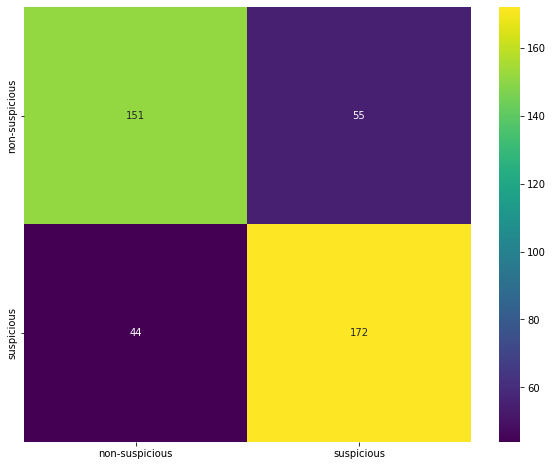

In [32]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(TRUE,PRED),annot=True,fmt='.3g',xticklabels=classes,yticklabels=classes,cmap='viridis')
plt.show()